Here we analyze the raw data obtained from the _QPC_dd_sim.py_ script.

In [59]:
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.integrate import simpson
from scipy import sparse

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
import os

from ast import literal_eval

from qutip import  *


In [60]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 18

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../plots/QPC_double_dot/"


In [61]:
def load_data(dir_route, file):
    # loading the simulation data
    with h5py.File(dir_route+file, 'r') as res_h5:
        Param_dict = json.loads(res_h5['metadata/parameters'][()])

        # load qpc data
        N_bond = res_h5["results/QPC_bond_density"][:]
        N_left = res_h5["results/QPC_left_density"][:]
        N_right = res_h5["results/QPC_right_density"][:]

        # load dot data
        N_d1 = res_h5["results/d1_density"][:]
        N_d2 = res_h5["results/d2_density"][:]

        # time range
        Times = res_h5["results/time"][:]
        
        # trajectories
        Trajectories = res_h5["results/trajectories"][:]
        
        # entanglement
        VN_entropy = res_h5["results/dot_VN_entropy"][:]
        Purity = res_h5["results/dot_purity"][:]  
        
        # Bloch sphere for DD dot_bloch_theta dot_bloch_phi
        DD_theta = res_h5["results/dot_bloch_theta"][:]
        DD_phi = res_h5["results/dot_bloch_phi"][:]

    res_h5.close()
    
    return Param_dict,Times, N_bond, N_left, N_right, N_d1, N_d2,Trajectories, VN_entropy, Purity, DD_theta, DD_phi
    

def get_timescale_data(Param_dict, Traject, Times, N_bond):
    # calculates the quantities relevant to the estimation of the hitting time
    # including the time it takes to hit the different parts of the QPC
    J = 1
    
    QPC_traject = Traject[:,:] # we only care about qpc trajectories for now
    # vector holding distance to origin of each lattice site
    r_vect = np.arange(0,Param_dict["L_qpc"])
    # position average in time
    x_av = np.asarray([np.dot(QPC_traject[:,i],r_vect) for i in range(0,len(Times)) ])

    # trajectory using Ehrenfest Therem
    vg = 2*J*np.sin(Param_dict["k0"])
    
    # time to get to the bond which is between [bond_index and bond_index+1]
    tau_0b = (Param_dict["bond_index"]-1)/vg

    # time at the bond defined at width at half maximum of the bond occupation
    # estimate FWHF with an interpolation
    spline = UnivariateSpline(Times, N_bond-np.max(N_bond)/2, s=0)
    bond_root = spline.roots() # find the roots
    if (len(bond_root)<2):
        print("not possible to estimate time at bond for ")
        print(Param_dict)
        tau_b = -Times[-1]
    else:
        # the first two roots yield the width at half maximum
        tau_b= bond_root[1] - bond_root[0]

    #time from bond to the wall
    tau_bL = (Param_dict["L_qpc"]-Param_dict["bond_index"]-2)/vg
    # total time
    tau_L = tau_0b + tau_b + tau_bL

    # time if there were no potential at bond
    tau_free = Param_dict["L_qpc"]/vg
    
    return tau_L, tau_free, tau_b, vg, x_av, bond_root 


def get_transmision_proba(Param_dict, J):
    # in the limit where we have very localized state the transmision probability is approximately that of the
    # one for K0
    V0 = J - 2*(Param_dict["Omega"] + Param_dict["J_prime"])
    T0 = 1/(1+(V0/Param_dict["k0"])**2)

    # the momentum distribution
    k_arr = np.linspace(-200,200, 5000)
    Psi0k_abs = (Param_dict["band_width"]**2/np.pi)**(1/2)*np.exp(-(Param_dict["band_width"]**2)*(k_arr-Param_dict["k0"])**2)
    # now with the wave packet weights
    T_k = 1/(1+(V0/k_arr)**2)
    T_tot = simpson(T_k*Psi0k_abs, dx=k_arr[1] - k_arr[0])
    
    return T0, T_tot
    
def find_nearest_index(array, value):
    # finds the index of the element closest to value
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    return idx


def get_partial_trace(Psi,NN):
    # calcualtes the partial trace from a STATEVECTOR Psi
    # NOT from the density matrix
    # Psi: Quobject from Qutip representing the wavefunction
    # NN: integer with the total size of the lattice

    n = 2**(NN-2) # QPC sites
    m = 2**2 # Double dot sites
    # get density matrix as a sparse array
    ps = sparse.csr_matrix(Psi.full())
    A = sparse.kron(ps, np.conj(ps.T))
    # convert to normal array for partial trace operation
    Adense = A.toarray()
    # trace out QPC sites and return reduced rho for DD as Quobject
    return Qobj(np.trace(Adense.reshape(n,m,n,m), axis1=0, axis2=2))

def get_entanglement(States, L ,tskip=5):
    # calculates several entanglement measures
    # States: list of Quobj containing the time evolution of the wavefunction
    # tskip: tells how many in between times to skip for faster computation
    purity_list = []
    entropy_list = []
    # skip some times otherwise its too heavy

    state_arr = States[0::tskip]
    for ti in range(0,len(state_arr)):
        # DD reduced density matrix
        rho_DD = get_partial_trace(state_arr[ti], L)
        # purity
        purity_list.append((rho_DD**2).tr())
        entropy_list.append(entropy_vn(rho_DD, sparse=False))
        
    return purity_list, entropy_list, tskip

def get_file_names_on(param_list, route):
    name_list = os.listdir(route)
    try:
        name_list.remove('.DS_Store')
    except:
        pass
    # gets a list of the hdf5 file names with t dependent data depending on the values in param_list
    for subs in param_list:
        # getting strings with parameters that we want
        name_list = list(filter(lambda x: subs in x, name_list))
    return name_list

In [62]:
data_route = "../data/sims/L=14/"
J=1


# Load processed data dataframe

In [63]:
data_full_df = pd.read_csv('../data/exp_pro/exploration_data_L=14.csv')
data_full_df.rename(columns={"band_width": "x_spread"}, inplace=True)
data_full_df = data_full_df.drop(["Unnamed: 0"], axis=1).drop_duplicates()
data_full_df.head()



,L_qpc,max_time,tsteps,bond_index,x_spread,k0,J_prime,t,Omega,vg,...,last_density_int,last_density_max,time_last_density_max,bond_density_max,min_purity,max_VN_entropy,entanglement_timeskip,T_mean,ddot0,kick
0,14,9.0,300,7,0.5,1.178097,1.0,0.4,0.0,1.847759,...,0.612752,0.716753,8.127090,0.541000,1.000000,2.059944e-07,20,0.919988,second,0.000000
1,14,9.0,300,7,2.0,0.981748,1.0,0.4,0.0,1.662939,...,0.249652,0.595915,7.464883,0.476412,1.000000,3.138038e-07,20,0.918258,fixed,0.000000
2,14,9.0,300,7,0.5,1.570796,1.0,0.9,0.0,2.000000,...,0.413836,0.718002,8.127090,0.542169,1.000000,1.783995e-07,20,0.920370,fixed,0.000000
3,14,9.0,300,7,2.0,0.981748,1.0,0.9,0.5,1.662939,...,0.294746,0.438285,7.765886,0.611862,0.925533,1.638991e-01,20,0.718974,second,0.765793
4,14,9.0,300,7,2.0,0.523599,1.0,0.9,0.7,1.000000,...,0.096028,0.257262,7.795987,0.420707,0.912945,1.853737e-01,20,0.497092,fixed,0.864258


Notice how the elements with time at bond < 0 are those with negative hitting times which correspond to negative velocities. Thi si clearly beyond the regime that we care about so we should ignore them

In [64]:
data_full_df[data_full_df["time_f_int"]<0].describe()
data_full_df = data_full_df[data_full_df["vg"]>0]

# here we can choose wether we want just the "fixed" by k0 initial conditions
# or the fully localized "second"
data_df = data_full_df[data_full_df["ddot0"]=="fixed"]


# Entanglement

## Making sure that QPC particles with different velocities hit the bond when the dot is at the same state

In [65]:
file_list = get_file_names_on(["om0.0","bw2.0","t0.2", "dd0fixed"], data_route)

file_list

['res_L14_maxtim9.0_bw2.0_k0.9817_jp1.0_t0.2_om0.0_dd0fixed.hdf5',
 'res_L14_maxtim9.0_bw2.0_k0.3927_jp1.0_t0.2_om0.0_dd0fixed.hdf5',
 'res_L14_maxtim9.0_bw2.0_k0.7854_jp1.0_t0.2_om0.0_dd0fixed.hdf5',
 'res_L14_maxtim9.0_bw2.0_k0.5236_jp1.0_t0.2_om0.0_dd0fixed.hdf5',
 'res_L14_maxtim9.0_bw2.0_k1.1781_jp1.0_t0.2_om0.0_dd0fixed.hdf5',
 'res_L14_maxtim9.0_bw2.0_k1.3744_jp1.0_t0.2_om0.0_dd0fixed.hdf5',
 'res_L14_maxtim9.0_bw2.0_k1.5708_jp1.0_t0.2_om0.0_dd0fixed.hdf5']

Text(0.5, 0, 'Time')

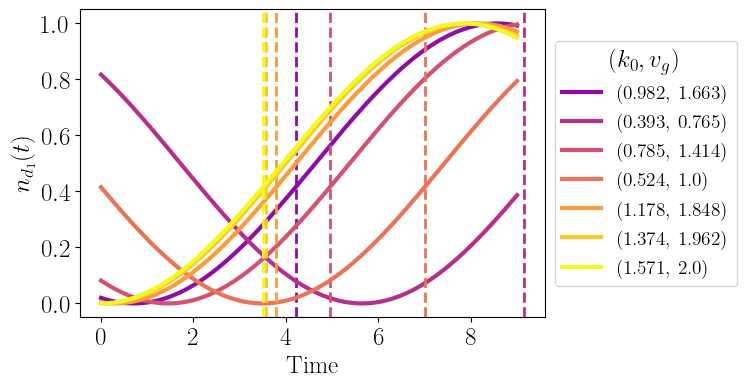

In [66]:
colors = plt.cm.plasma(np.linspace(0.3,1,len(file_list)))

fig, ax = plt.subplots(figsize=(6,4))

for i in range(0,len(file_list)):
    file_name = file_list[i]
    param_dict, times, n_bond, n_left, n_right, n_d1, \
        n_d2, traject, VN_entropy, purity, _, _ = load_data("../data/sims/L=14/",file_name)
  
    # calculate the time it takes it to hit the bond (scattering approx)
    vg = 2*np.sin(param_dict["k0"])
    tau_to_bond = param_dict["bond_index"]/vg
    
    lab = "("+str(round(param_dict["k0"],3)) + ", " + str(round(vg,3))+")" 
    
    plt.plot(times, n_d1, linewidth=3, label=lab , c=colors[i])
    
    plt.axvline(tau_to_bond, linestyle="dashed",c=colors[i], linewidth=2)
    
plt.legend(title=r"$(k_0, v_g)$",loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylabel(r"$n_{d_1}(t)$")
plt.xlabel(r"Time")



## constant omega, constant t constant bandwidth so we can look at **varying $k_0$**

In [67]:
file_list = get_file_names_on(["om0.3","bw2.0","t0.2", "dd0fixed"], data_route)
file_list

['res_L14_maxtim9.0_bw2.0_k0.9817_jp1.0_t0.2_om0.3_dd0fixed.hdf5',
 'res_L14_maxtim9.0_bw2.0_k0.5236_jp1.0_t0.2_om0.3_dd0fixed.hdf5',
 'res_L14_maxtim9.0_bw2.0_k0.3927_jp1.0_t0.2_om0.3_dd0fixed.hdf5',
 'res_L14_maxtim9.0_bw2.0_k0.7854_jp1.0_t0.2_om0.3_dd0fixed.hdf5',
 'res_L14_maxtim9.0_bw2.0_k1.5708_jp1.0_t0.2_om0.3_dd0fixed.hdf5',
 'res_L14_maxtim9.0_bw2.0_k1.1781_jp1.0_t0.2_om0.3_dd0fixed.hdf5',
 'res_L14_maxtim9.0_bw2.0_k1.3744_jp1.0_t0.2_om0.3_dd0fixed.hdf5']

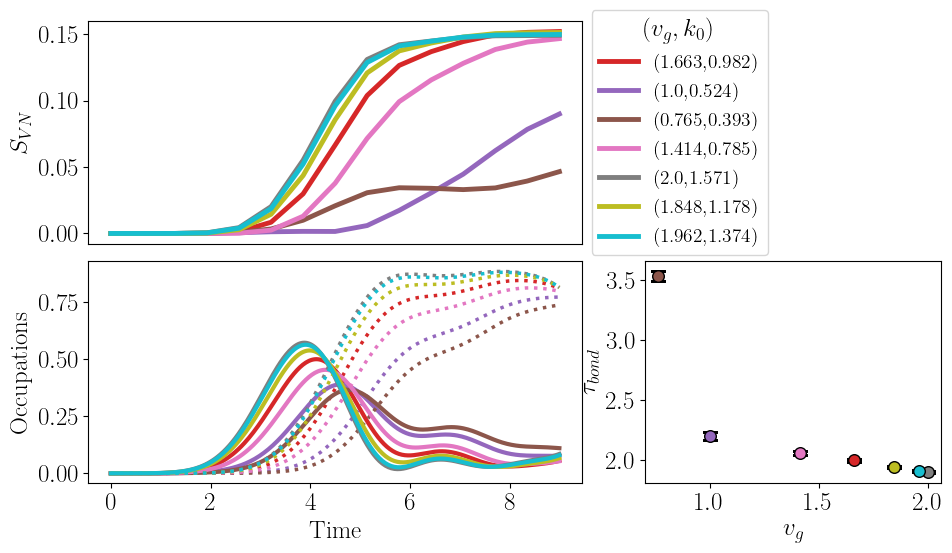

In [68]:
colors = plt.cm.tab10(np.linspace(0.3,1,len(file_list)))

# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2, width_ratios=[1,0.6])

plt.figure(figsize=(11,6))

for i in range(0,len(file_list)):
    file_name = file_list[i]
    param_dict, times, n_bond, n_left, n_right, n_d1, \
        n_d2, traject, VN_entropy, purity, _,_ = load_data("../data/sims/L=14/",file_name)

    # calculate data for the time scales
    tau_L, tau_free, tau_b, vg, x_av, bond_root  = get_timescale_data(param_dict, traject, times, n_bond)   
    
    # calculate the time it takes it to hit the bond (scattering approx)
    tau_to_bond = param_dict["bond_index"]/vg
    # condition to get error bars for tau_b from df
    cond = (data_df["t"] == param_dict["t"]) & (data_df["Omega"] == param_dict["Omega"]) \
            & (data_df["x_spread"] == param_dict["band_width"])

    
    k0 = param_dict["k0"]
    lab = "(" + str(round(vg,3)) + "," + str(round(k0,3)) + ")"
    times_coarse = times[::param_dict["entropy_t_skip"]]
    
    # plot first row
    ax = plt.subplot(gs[0, 0]) # make it span both columns
    ax.plot(times_coarse, VN_entropy, label=lab, linewidth=3.5, c=colors[i])
    ax.set_ylabel(r"$S_{VN}$")
    ax.set_xticks([])
    ax.legend(title=r"$(v_g, k_0)$", loc='center left', bbox_to_anchor=(1, 0.5))

    # plot second row
    ax = plt.subplot(gs[1, 0]) # row 0, col 0
    ax.plot(times,n_right, linewidth=2.5, linestyle="dotted", c=colors[i])  
    ax.plot(times,n_bond, label=lab, linewidth=3, c=colors[i])
    
    ax.set_ylabel(r"Occupations")
    ax.set_xlabel(r"Time")

    ax = plt.subplot(gs[1, 1]) # row 0, col 1
    
    # Add error bars 
    ax.errorbar(data_df[cond]["vg"], data_df[cond]["time_at_bond"], yerr=data_df[cond]["bond_fit_error"], 
            fmt="x", elinewidth=3,ecolor='black', capsize=5, capthick=2)
    
    ax.scatter(vg, tau_b, c=[colors[i]], s=70, edgecolor='black', zorder=7)
    ax.set_ylabel(r"$\tau_{bond}$")
    ax.set_xlabel(r"$v_g$")

plt.subplots_adjust(wspace=0.16, hspace=0.08)


# Dataframe summary

## Correlation Matrix


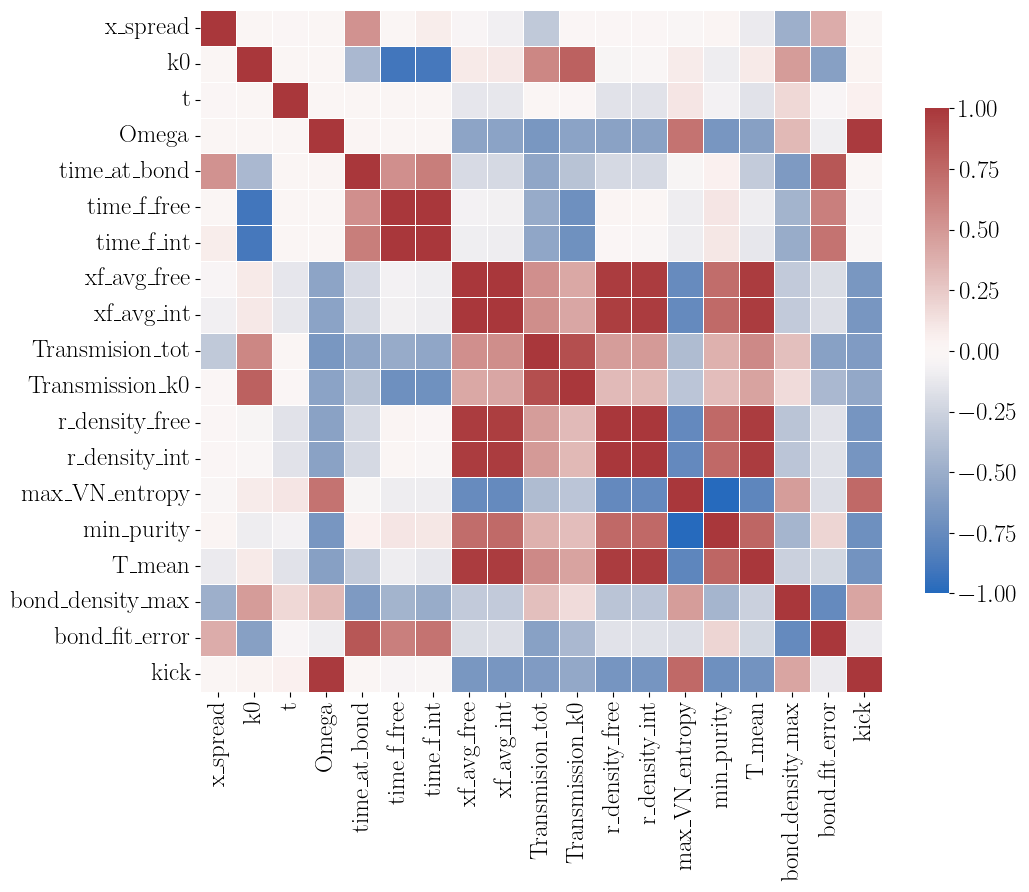

In [79]:
rel_params = ["x_spread","k0","t", "Omega"]
rel_results = ['time_at_bond', 'time_f_free',
       'time_f_int', 'xf_avg_free', 'xf_avg_int', 'Transmision_tot',
       'Transmission_k0', 'r_density_free', 'r_density_int',"max_VN_entropy","min_purity", 
        "T_mean", "bond_density_max","bond_fit_error", "kick"]
corr = data_df[rel_params+rel_results].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, square=True, linewidths=.5, vmin=-1, vmax=1 ,cmap = "vlag",cbar_kws={"shrink": .7})


plt.savefig(fig_route+"correlations.pdf")



## Time at bond

<Axes: xlabel='x_spread', ylabel='k0'>

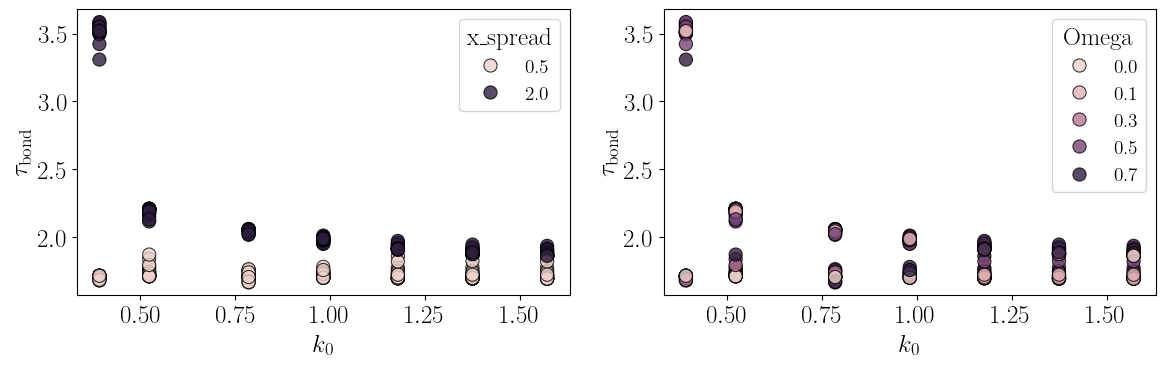

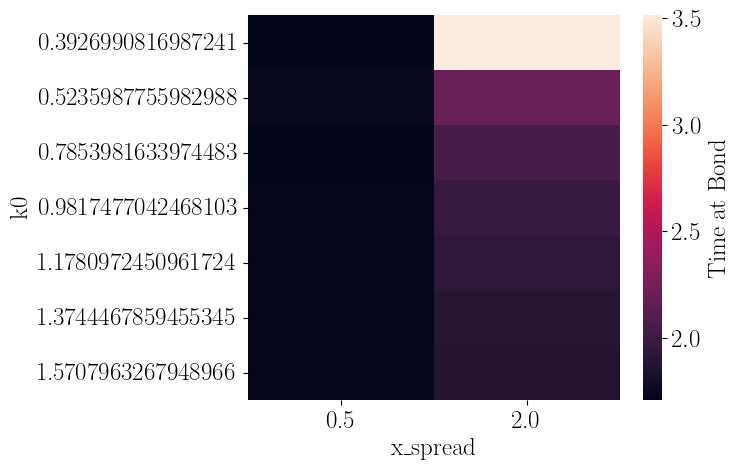

In [70]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.scatterplot(data=data_df, x="k0", y="time_at_bond",hue="x_spread" , s=90,alpha=0.8,edgecolor='black',
                ax=ax[0])
sns.scatterplot(data=data_df, x="k0", y="time_at_bond",hue="Omega" ,s=90,alpha=0.8,edgecolor='black',
               ax=ax[1])

ax[0].set_xlabel(r"$k_0$")
ax[0].set_ylabel(r"$\tau_{\rm{bond}}$")

ax[1].set_xlabel(r"$k_0$")
ax[1].set_ylabel(r"$\tau_{\rm{bond}}$")
plt.tight_layout()

# plt.savefig(fig_route+"hitting_time_k0.pdf")

fig, ax = plt.subplots(1,1, figsize=(6,5))

bondmap = data_df.pivot_table(index="k0", columns="x_spread", values="time_at_bond")

sns.heatmap(bondmap,cbar_kws={'label': "Time at Bond"})

## Hitting time

make a density plot to get the correlations between the sim parameters and observed values. 
To see some kinf of relationship between the values we probably have to work by keeping one parameter or more parameter constant and then varying the rest, We can use hues for this.

Compare the time_last_density with the other two estimated times.
Also look at the maximum average x

1. Distringuish between values of omega and dot hopping because these change everything
2. compare the two estimated times with the density time
3. compare the maximum average x ant the group velocity x
4. compare the transmission coeffients


<Axes: xlabel='x_spread', ylabel='k0'>

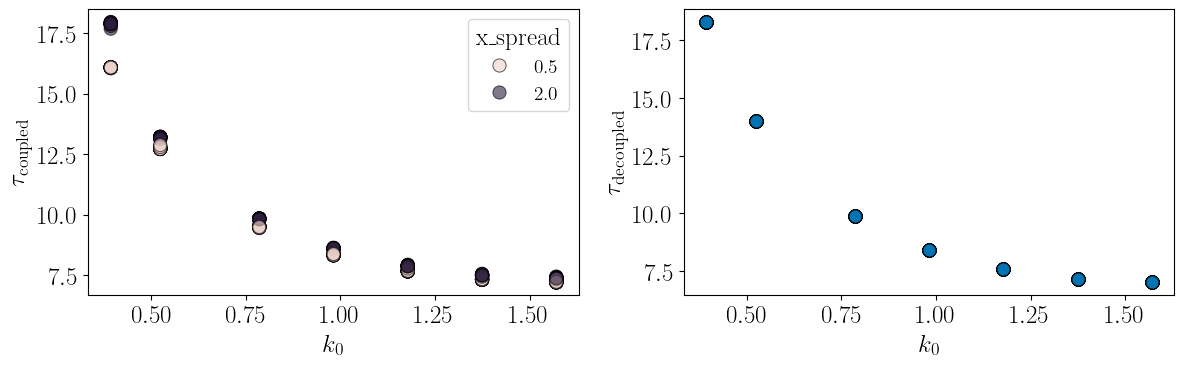

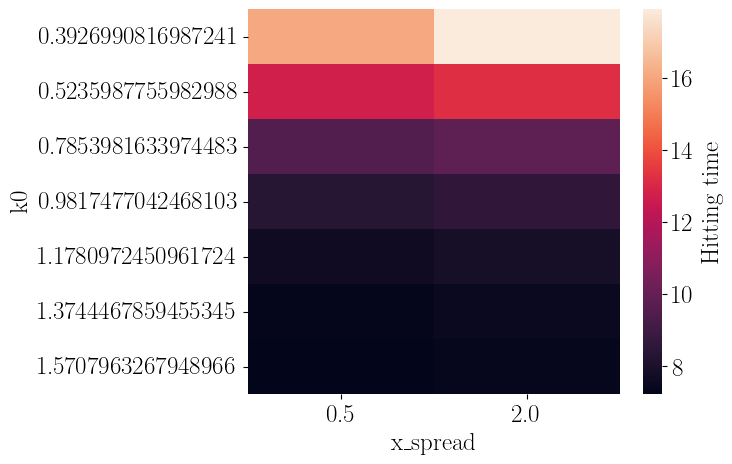

In [71]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.scatterplot(data=data_df, x="k0", y="time_f_int",hue="x_spread" , s=90, alpha=0.6,edgecolor='black',
                ax=ax[0])
sns.scatterplot(data=data_df, x="k0", y="time_f_free",s=90,alpha=0.8,edgecolor='black',
               ax=ax[1])

ax[0].set_xlabel(r"$k_0$")
ax[0].set_ylabel(r"$\tau_{\rm{coupled}}$")

ax[1].set_xlabel(r"$k_0$")
ax[1].set_ylabel(r"$\tau_{\rm{decoupled}}$")
plt.tight_layout()

# plt.savefig(fig_route+"hitting_time_k0.pdf")

fig, ax = plt.subplots(1,1, figsize=(6,5))

bondmap = data_df.pivot_table(index="k0", columns="x_spread", values="time_f_int")

sns.heatmap(bondmap,cbar_kws={'label': "Hitting time"})


# Transmision probability and density at bond

Average the transmision probability from 6 to 10 to get rid of those finite size effects and pick a values tht makes a bit more sense

<Axes: xlabel='k0', ylabel='bond_density_max'>

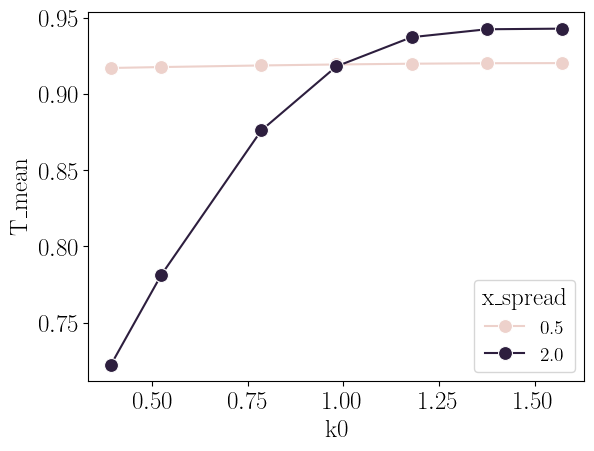

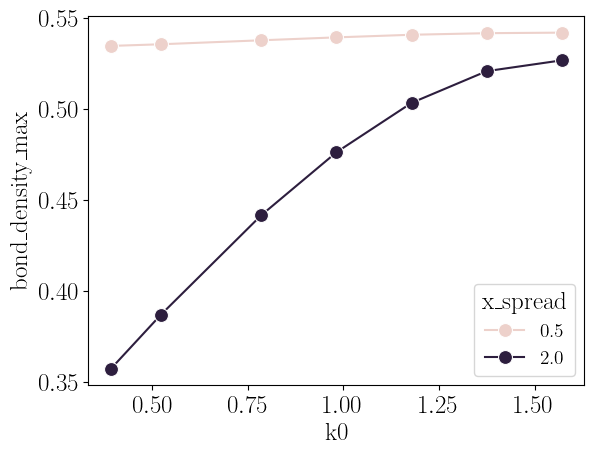

In [72]:
plt.figure()

cond = (data_df['Omega']==0.3) & (data_df['t']==0.0)
curr_df = data_df[cond].sort_values(by="k0")
sns.lineplot(data = curr_df, x="k0", y="T_mean", hue="x_spread", marker='o', markersize=10)

plt.figure()
sns.lineplot(data=curr_df, x="k0", y="bond_density_max", hue="x_spread", marker='o', markersize=10)

# Max entropy production

## Several different variables

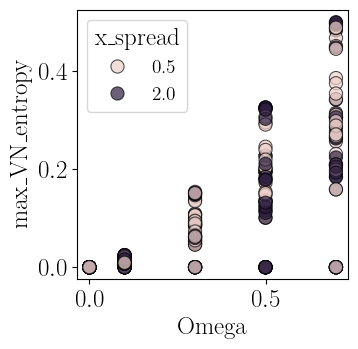

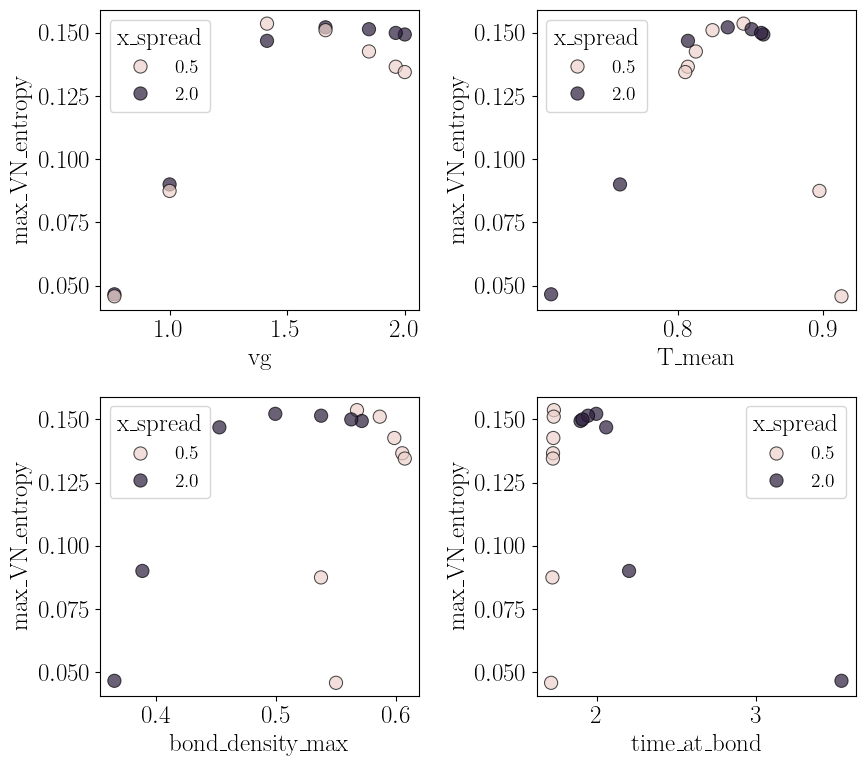

In [80]:
fig, ax = plt.subplots(1,1, figsize=(3.5,3.5))
sns.scatterplot(data=data_df, x="Omega", y="max_VN_entropy",hue="x_spread" , s=90, alpha=0.7,edgecolor='black')

# choose a specific Omega
chosen_omega = 0.3
cond = (data_df["Omega"]==0.3) & (data_df["t"]==0.2) 
curr_df = data_df[cond]

fig, ax = plt.subplots(2,2, figsize=(9,8))

sns.scatterplot(data=curr_df, x="vg", y="max_VN_entropy",hue="x_spread" , s=90, alpha=0.7,edgecolor='black',
                ax=ax[0,0])

sns.scatterplot(data=curr_df, x="T_mean", y="max_VN_entropy",hue="x_spread" , s=90, alpha=0.7, 
                edgecolor='black',ax=ax[0,1])

sns.scatterplot(data=curr_df, x="bond_density_max", y="max_VN_entropy",hue="x_spread" , s=90, alpha=0.7,
                edgecolor='black',ax=ax[1,0])


sns.scatterplot(data=curr_df, x="time_at_bond", y="max_VN_entropy",hue="x_spread" , s=90, alpha=0.7,
                edgecolor='black',ax=ax[1,1])

plt.tight_layout()

## Kick

Which I define as $$\Omega \int dt\, n(t) \propto S_{VN}$$

<Axes: xlabel='kick', ylabel='max_VN_entropy'>

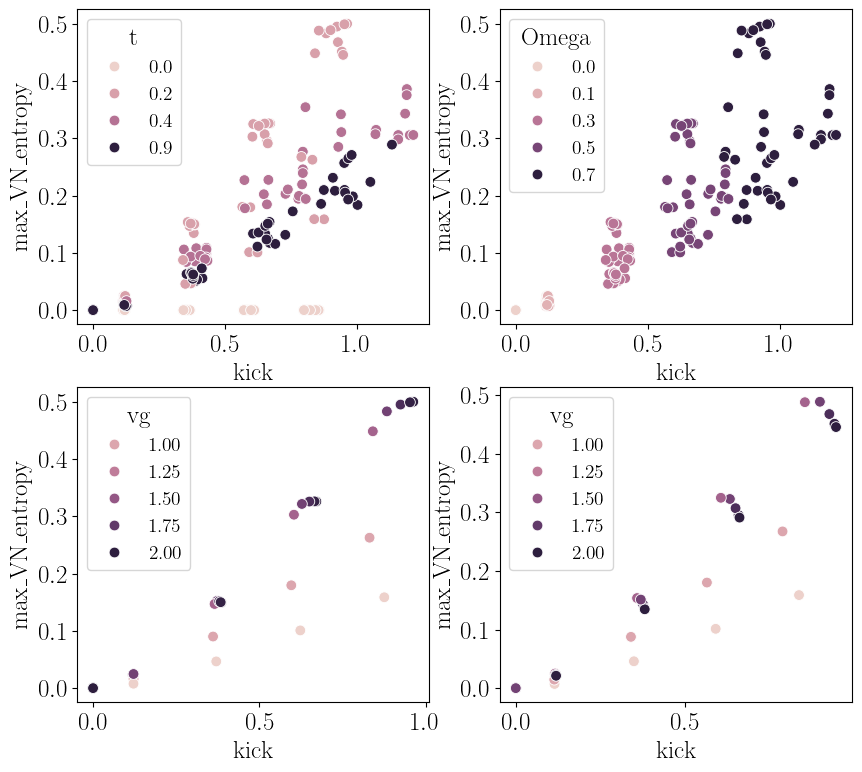

In [126]:
fig, ax = plt.subplots(2,2, figsize=(10,9))

sns.scatterplot(data=data_df, x="kick", y="max_VN_entropy", hue="t", s=60, ax=ax[0,0])
sns.scatterplot(data=data_df[data_df["t"]>0], x="kick", y="max_VN_entropy", hue="Omega", s=60, ax=ax[0,1])
cond = (data_df["t"]==0.2) & (data_df["x_spread"]==2.0)
sns.scatterplot(data=data_df[cond], x="kick", y="max_VN_entropy", hue="vg", s=60, ax=ax[1,0])

cond = (data_df["t"]==0.2) & (data_df["x_spread"]==0.5)
sns.scatterplot(data=data_df[cond], x="kick", y="max_VN_entropy", hue="vg", s=60, ax=ax[1,1])


# Individual examples

Test with the analytic scattering aplitude

In [52]:
"res_L14_maxtim9.0_bw2.0_k0.3927_jp1.0_t0.2_om0.3_dd0fixed.hdf5"
"res_L14_maxtim9.0_bw2.0_k1.5708_jp1.0_t0.2_om0.3_dd0fixed.hdf5"

file_name = "res_L14_maxtim9.0_bw2.0_k1.5708_jp1.0_t0.2_om0.3_dd0fixed.hdf5"

param_dict, times, n_bond, n_left, n_right, n_d1, n_d2, traject, VN_entropy, purity,\
                dd_theta, dd_phi = load_data(data_route,file_name)
J=1

# calculate data for the time scales
tau_L, tau_free, tau_b, vg, x_av, bond_root  = get_timescale_data(param_dict, traject, times, n_bond)                        
xvg = vg*times # trajectory using group velocity


## Timescales of the system

Three different times: time it takes to reach the bond, time spent at bond and time to gor from bond to the end.

The time at the bond is found as the full width at half-maximum of the bond occupations. The others are approximated as a freely propagating wave with the grpup velocity of the tight binding chain

For full width at half max: https://stackoverflow.com/questions/10582795/finding-the-full-width-half-maximum-of-a-peak

estimated time to hit the far wall with coupling:  7.396169210783457
estimated time to hit the far wall without coupling:  7.0


'plt.savefig(fig_route+"traj_L={}_tdot={}_K={}_bw={}_Jp={}_om={}.png".format(\n            param_dict["L_qpc"], param_dict["t"], param_dict["k0"], param_dict["band_width"],\n            param_dict["J_prime"], param_dict["Omega"]))'

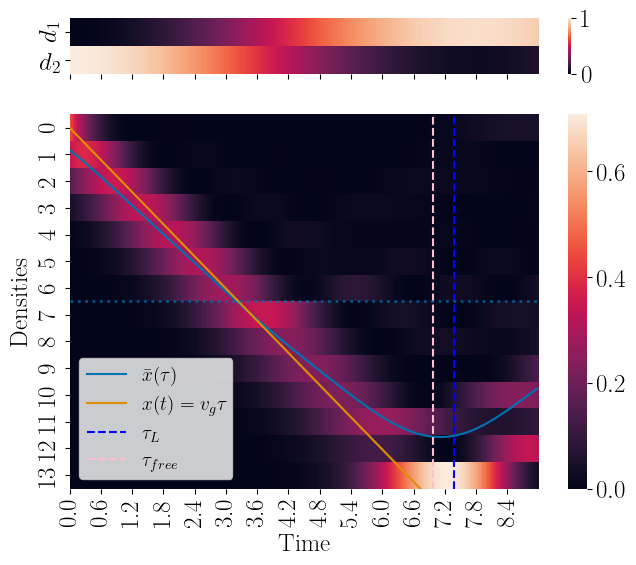

In [53]:

print("estimated time to hit the far wall with coupling: ", tau_L)
print("estimated time to hit the far wall without coupling: ", tau_free)

fig, ax = plt.subplots(2,1,figsize=(7,6), sharex=True ,gridspec_kw={'height_ratios': [0.15, 1]})

# n_d1
sns.heatmap([n_d1,n_d2],ax=ax[0])

# plot the occupations as a heatmap with lattice site in the y axis and time on the x
sns.heatmap(traject,ax=ax[1])

ax[1].plot(x_av+0.5,label=r"$\bar{x}(\tau)$") # the 0.5 is so the values correspond to the ticks so its easier to visualize
ax[1].plot(xvg+0.5, label= r"$x(t)=v_g \tau$")
# plot time or arrival in index coordinates
delta_tau = times[1]- times[0]
ax[1].axvline(tau_L/delta_tau, label=r"$\tau_{L}$", linestyle="dashed", c='blue')
ax[1].axvline(tau_free/delta_tau, label=r"$\tau_{free}$", linestyle="dashed", c="pink")

ax[1].set_xlabel("Time")
ax[1].set_ylabel("Densities")

ax[1].axhline(param_dict["bond_index"], alpha=0.7,linestyle='dotted' ,linewidth=2.0)

# lattice ticks
ax[0].set_yticks([0.5,1.5], [r"$d_1$",r"$d_2$"])

site_ticks = list(range(0,param_dict["L_qpc"])) # [r"$d_1$",r"$d_2$"]
tick_posy = np.asarray(range(0,len(site_ticks))) + 0.5
ax[1].set_yticks(tick_posy,site_ticks);

# time ticks
tick_posx = np.arange(0,len(times),20)
xtick_label = np.around(tick_posx*(delta_tau),decimals=1)
ax[1].set_xticks(tick_posx,xtick_label);

plt.legend(loc='lower left')
plt.tight_layout()

"""plt.savefig(fig_route+"traj_L={}_tdot={}_K={}_bw={}_Jp={}_om={}.png".format(
            param_dict["L_qpc"], param_dict["t"], param_dict["k0"], param_dict["band_width"],
            param_dict["J_prime"], param_dict["Omega"]))"""



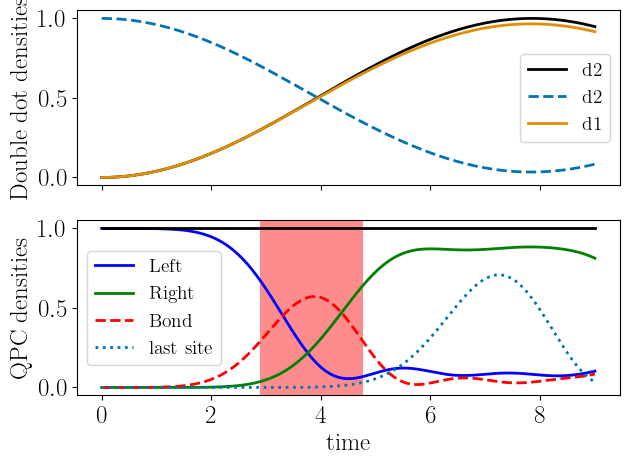

In [54]:
fig, ax = plt.subplots(2,1, figsize=(7,5),sharex=True)
wr = param_dict["t"]
rabi_osc = np.sin(wr*times)**2

# in dot
ax[0].plot(times, rabi_osc, linewidth=2.0, alpha=1.0, c='black' ,label="d2")
ax[0].plot(times, n_d2, linewidth=2.0, alpha=1.0, linestyle="dashed" ,label="d2")
ax[0].plot(times, n_d1, linewidth=2.0, alpha=1.0, label="d1")

ax[1].plot(times, n_left, label="Left", c='blue', linewidth=2)
ax[1].plot(times,n_right,label="Right", c='green',linewidth=2)
ax[1].plot(times,n_bond,label="Bond", linestyle="dashed", c='red',linewidth=2)
ax[1].plot(times,traject[-1],label="last site", linestyle="dotted",linewidth=2)
ax[1].plot(times,n_left+n_right+n_bond, c = 'black'
        ,linewidth=2)

# plot full width at half maximum at bond
ax[1].axvspan(bond_root[0], bond_root[1], facecolor='r', alpha=0.45)

ax[0].legend()
ax[0].set_ylabel("Double dot densities")

ax[1].set_xlabel("time")
ax[1].set_ylabel("QPC densities")
ax[1].legend()




## Bloch sphere visualization

By comparing the reduced density matrix of the double dot in the decoupled and coupled cases in the bloch representation we can get a better idea of what the backaction is doing here. For comparisson we also calcualte the quantities for an analogous decoupled system.

Notice that the coupled case, only plots the vectors in one side of the sphere and the ones that should be on the otherside are also flipped there. The reason is that we use arccos to get those angles which only has a rnage from -1 to 1 between -pi/2 to pi/2 and as a result it ends up projecting the oscillations beyond the cosine period onto the same range of angles 

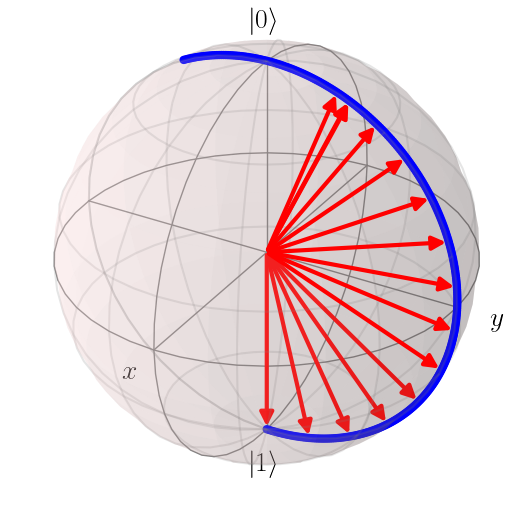

In [55]:
# First the decoupled system
# now generate the expected free oscillations
w = param_dict["t"]
theta_free = 2*w*times
phi_free = -0.5*np.pi

# writting out free case solution in spherical coordinates
x_ = np.sin(theta_free+np.pi)*np.cos(phi_free)
y_ = np.sin(theta_free+np.pi)*np.sin(phi_free)
z_ = np.cos(theta_free+np.pi)
# the + pi in the angle is because we start the system in the 1 state instead of the 0 
free_points = [x_, y_, z_]

# Now plot the numerical coupled case

x_ = np.sin(dd_theta+np.pi)*np.cos(dd_phi)
y_ = np.sin(dd_theta+np.pi)*np.sin(dd_phi)
z_ = np.cos(dd_theta+np.pi)
coupled_vectors = [[i,j,k] for i,j,k in zip(x_.real,y_.real,z_.real)]
# make all vectors the same color

bs = Bloch()
bs.add_points(free_points)
bs.add_vectors(coupled_vectors)
bs.vector_color = ["red"]*len(coupled_vectors) 

bs.show()

Text(0, 0.5, 'Bloch Angles')

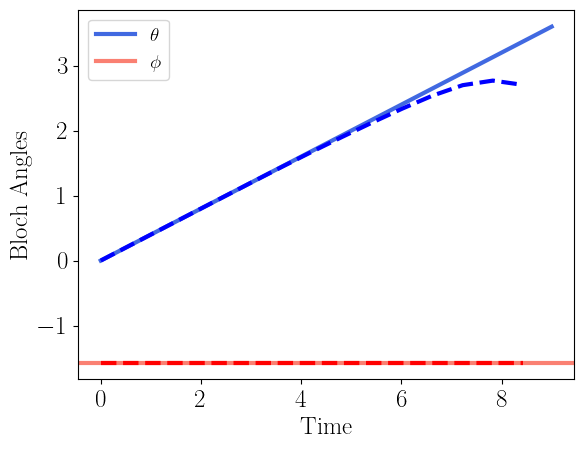

In [56]:
tskip = param_dict["entropy_t_skip"]

plt.figure()

plt.plot(times, theta_free, c='royalblue', linewidth=3, label=r"$\theta$")
plt.axhline(phi_free, c = "salmon",linewidth=3, label=r"$\phi$")

plt.plot(times[::tskip], dd_theta.real, c='blue', linestyle="dashed", linewidth=3)
plt.plot(times[::tskip], dd_phi.real, c='red', linestyle="dashed", linewidth=3)
plt.legend()
plt.xlabel(r"Time")
plt.ylabel(r"Bloch Angles")


## Comparisson with Scattering Calculations

For small enough $t$ (double dot hopping) we can approximate the bond pottential as a constant delta function potential. Therefore we can compare to some analytical results using scattering 

In [81]:
T0, T_tot = get_transmision_proba(param_dict, J)


'\nplt.savefig(fig_route+"scattering_L={}_tdot={}_K={}_bw={}_Jp={}_om={}.pdf".format(\n            param_dict["L_qpc"], param_dict["t"], param_dict["k0"], param_dict["band_width"],\n            param_dict["J_prime"], param_dict["Omega"]))\n'

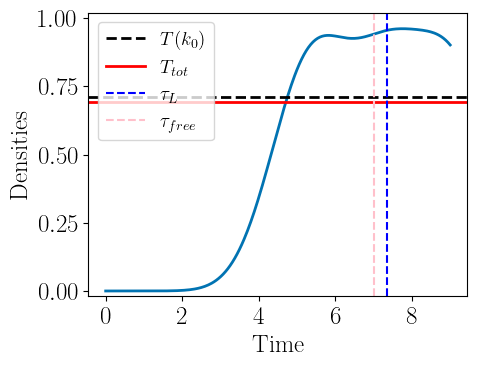

In [82]:
fig, ax = plt.subplots(1,1,figsize=(5,4))

plt.plot(times, n_right,linewidth=2)

ax.axhline(T0, linestyle='dashed',c="black", label= r"$T(k_0)$", linewidth=2)
ax.axhline(T_tot, linestyle='solid',c="red", label= r"$T_{tot}$", linewidth=2)

ax.axvline(tau_L, label=r"$\tau_{L}$", linestyle="dashed", c='blue')
ax.axvline(tau_free, label=r"$\tau_{free}$", linestyle="dashed", c="pink")

plt.ylim(-0.02,1.02)
#plt.xlim(min(times),max(times))


plt.xlabel('Time')
plt.ylabel("Densities")
plt.legend()

plt.tight_layout()
"""
plt.savefig(fig_route+"scattering_L={}_tdot={}_K={}_bw={}_Jp={}_om={}.pdf".format(
            param_dict["L_qpc"], param_dict["t"], param_dict["k0"], param_dict["band_width"],
            param_dict["J_prime"], param_dict["Omega"]))
"""


# Constant $t$ , $k$ and variable $\Omega$

here we always look at $\Omega = {0.1, 0.5,1.0 }$


In [83]:
Lqpc = 14
maxtime = 10.0
bw = 1.5
k0 = 2.0
jp = 1.0
t = 0.2
dd_init = "second"
file_list = [
            "res_L{}_maxtim{}_bw{}_k{}_jp{}_t{}_om0.1_dd0{}.hdf5".format(Lqpc,maxtime,bw,k0,jp,t,dd_init), 
            "res_L{}_maxtim{}_bw{}_k{}_jp{}_t{}_om0.5_dd0{}.hdf5".format(Lqpc,maxtime,bw,k0,jp,t,dd_init), 
            "res_L{}_maxtim{}_bw{}_k{}_jp{}_t{}_om1.0_dd0{}.hdf5".format(Lqpc,maxtime,bw,k0,jp,t,dd_init), 
            ]


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../data/sims/L=14/res_L14_maxtim10.0_bw1.5_k2.0_jp1.0_t0.2_om0.1_dd0second.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

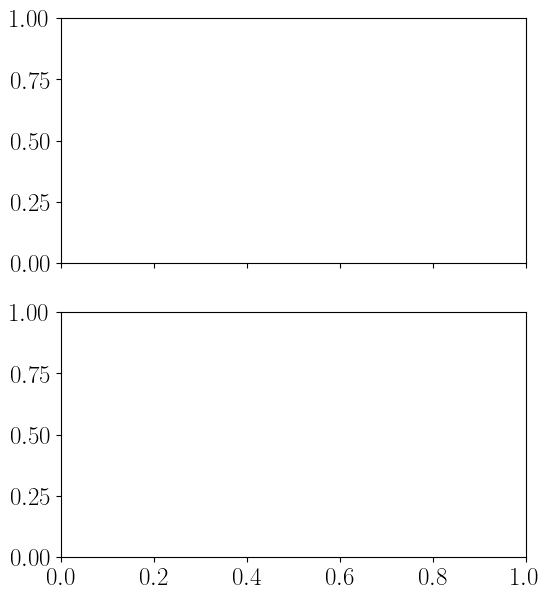

In [84]:
colors = plt.cm.Blues(np.linspace(0.4,1,len(file_list)))

tick_positions = []
omega_labels = []

fig, axd = plt.subplots(2,1,figsize=(6,7),sharex=True)

for f in range(0,len(file_list)):
    file_ = file_list[f]
    # for the double dots
    param_dict, times, n_bond, n_left, n_right, n_last, n_d1, n_d2, traject = load_data(data_route, file_)
    Om = param_dict["Omega"]
    
    print(param_dict)
    
    axd[0].plot(times, n_d2, c = colors[f], alpha=0.8 ,linewidth=2.5, 
                label=r'$\Omega={}$'.format(param_dict["Omega"]))    
    
    axd[1].plot(times,n_last+(2.5*Om), linestyle="dotted",linewidth=2,c='black')
    axd[1].plot(times, n_left+(2.5*Om), c = colors[f], alpha=1.0 ,linewidth=2.5,)
    axd[1].plot(times, n_right+(2.5*Om), c = colors[f], alpha=1.0 ,linewidth=2.5,linestyle="dashed")
    axd[1].plot(times, n_bond+(2.5*Om), c = colors[f], alpha=1.0 ,linewidth=2.5,linestyle="dashdot")

    tick_positions.append(2.5*Om+0.5)
    omega_labels.append(Om)  
    
    # for the trajectories ----------------
    fig_traj, ax_traj = plt.subplots(1,1,figsize=(7.0,6))
    
    # plot the occupations as a heatmap with lattice site in the y axis and time on the x
    sns.heatmap(traject, ax=ax_traj)
    ax_traj.set_xlabel("steps")
    ax_traj.set_ylabel("densities")
    ax_traj.axhline(param_dict["bond_index"]+1,c='blue')

    site_ticks = list(range(0,13)) + ["d1","d2"]
    tick_pos = np.asarray(range(0,15)) + 0.5

    ax_traj.set_yticks(tick_pos,site_ticks);
    fig_traj.tight_layout()
    """fig_traj.savefig("../plots/QPC_double_dot/traj_L={:.2f}_tdot={:.2f}_K={}_Jp={}_dd_{}_om={}.png".format(Lqpc, t, k0,jp,
                                                                                                           dd_init,Om),
                         dpi=400)"""
    
axd[1].plot(0,0,linestyle="dotted",linewidth=2.0,label='Last', c='black')
axd[1].plot(0,0,linestyle="solid",linewidth=2.5,label='Left', c=colors[1])
axd[1].plot(0,0,linestyle="dashed",linewidth=2.5,label='Right',c=colors[1])
axd[1].plot(0,0,linestyle="dashdot",linewidth=2.5,label='bond',c=colors[1])


# analytic expectation for decoupled case
rabi_osc = np.sin(t*times)**2

axd[0].plot(times, rabi_osc, linewidth=5, alpha=0.8, c='red' ,label=r"$\Omega = 0$",zorder=0)

axd[0].set_title(r"$t = {}, k = {}, J_p={}$".format(t,k0, jp))
axd[0].legend()
axd[0].set_ylabel(r"$n_{d1}$")
axd[0].set_box_aspect(1/3.5)
axd[0].xaxis.set_ticks_position('none') 

axd[1].set_xlabel(r"Time")
axd[1].set_ylabel(r"$\Omega / n_{s}$")
axd[1].set_yticks(tick_positions, omega_labels)
axd[1].legend()
fig.subplots_adjust(hspace=-0.62)


"""fig.tight_layout()
fig.savefig("../plots/QPC_double_dot/density_sums_L={:.2f}_tdot={:.2f}_K={}_Jp={}_bw={}_dd_{}.pdf".format(Lqpc, t,
                                                                                                 k0,jp,bw,dd_init))
"""